In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
# Read data
new_dataset_efmjieh1 = pd.read_csv("imputedfi.csv")
# Specify the variables to scale
numerical_variables = ["efalimo", "efalip", "efcapgn", "efccar", "efchtxb", 
"efcpqpp", "efearng", "efgi", "efgstxc", "efgtr", "efinva", "efoasgi", "efogovtr", "efothinc", "efpen", "efpenrec", "efphpr", "efpvtxc", "efrppc", "efrspwi", "efsapis", "efsemp", 
"efsize", "efuiben", "efwkrcp", "efagofmp", "efagyfmp", "hlev2g"]

# Specify categorical variables
categorical_variables = ["eftyp", "prov", "dwltyp", "dwtenr", "marstp", "efmjsi","sex","immst","uszgap"]
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['fschhldm'] >= 1, 'fschhldm'] = 1

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Create the target and features
y = new_dataset_efmjieh1['fschhldm']
X = new_dataset_efmjieh1.drop(columns=['fschhldm'])

# Define pipeline for scaling numerical features and one-hot encoding categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_variables),
        ('cat', categorical_transformer, categorical_variables)
    ]
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Create a mask for SMOTENC after one-hot encoding
# True for categorical features and False for numerical features
categorical_features_mask = [col in categorical_variables for col in X.columns]

# Apply SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features_mask, random_state=42, sampling_strategy='minority')
X_resampled, y_resampled = smote_nc.fit_resample(X_preprocessed, y)

# Encode the labels
le = LabelEncoder()
y_resampled_ready = le.fit_transform(y_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train_ready, y_test_ready = train_test_split(X_resampled, y_resampled_ready, random_state=42, stratify=y_resampled_ready)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, n_jobs = -1)


In [3]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier()

# Random search of parameters using 3 fold cross validation
random_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the model
random_search.fit(X_train, y_train_ready)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time= 2.0min
[CV] END max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time= 2.1min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time= 6.5min
[CV] END max_depth=40, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.3min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=168.0min
[CV] END max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=128.3min
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=18.1min
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 2.0min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time= 2.7min
[CV] END max_d

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26545
           1       1.00      1.00      1.00     26546

    accuracy                           1.00     53091
   macro avg       1.00      1.00      1.00     53091
weighted avg       1.00      1.00      1.00     53091

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      8849
           1       0.94      0.89      0.92      8848

    accuracy                           0.92     17697
   macro avg       0.92      0.92      0.92     17697
weighted avg       0.92      0.92      0.92     17697



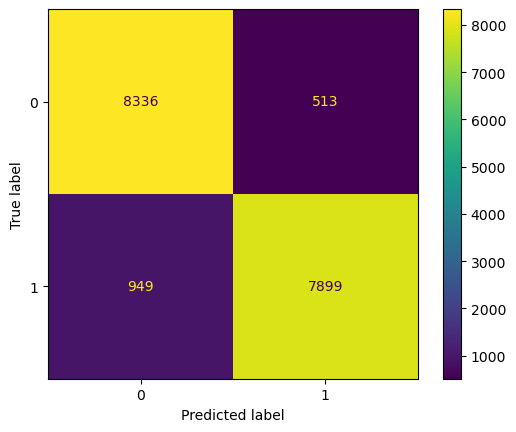

In [4]:
# Define and fit the classifier with the best parameters
clf_r = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                             max_depth=best_params['max_depth'], 
                             min_samples_split=best_params['min_samples_split'],
                             min_samples_leaf=best_params['min_samples_leaf'], 
                             random_state=42, 
                             n_jobs=-1)
clf_r.fit(X_train, y_train_ready)

# Make predictions
y_hat_train = clf_r.predict(X_train)
y_hat_test = clf_r.predict(X_test)

# Print classification reports
print(classification_report(y_train_ready, y_hat_train))
print(classification_report(y_test_ready, y_hat_test))

# Plot confusion matrix
cm = confusion_matrix(y_test_ready, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 
plt.show()


In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Compute training and test accuracy
train_acc = accuracy_score(y_train_ready, y_hat_train)
test_acc = accuracy_score(y_test_ready, y_hat_test)

print("Training Accuracy: {:.2f}%".format(train_acc * 100))
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

# Compute probabilities
y_train_proba = clf_r.predict_proba(X_train)[:, 1]
y_test_proba = clf_r.predict_proba(X_test)[:, 1]

# Compute ROC AUC
roc_auc_train = roc_auc_score(y_train_ready, y_train_proba)
roc_auc_test = roc_auc_score(y_test_ready, y_test_proba)

print("Training ROC AUC: {:.2f}".format(roc_auc_train))
print("Test ROC AUC: {:.2f}".format(roc_auc_test))


Training Accuracy: 100.00%
Test Accuracy: 91.74%
Training ROC AUC: 1.00
Test ROC AUC: 0.97


In [6]:
# Save all the models and transformers
import joblib

# Save preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Save SMOTENC
joblib.dump(smote_nc, 'smote_nc.pkl')

# Save label encoder
joblib.dump(le, 'le.pkl')

# Save RandomSearchCV
joblib.dump(random_search, 'random_search.pkl')

# Save RandomForest model with best params
clf_best_params = random_search.best_estimator_
joblib.dump(clf_best_params, 'clf_best_params.pkl')


['clf_best_params.pkl']

In [7]:
joblib.dump(best_params, 'best_params.pkl')

['best_params.pkl']